## Data loading

In [1]:
import numpy as np
from numpy import genfromtxt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Visualize transformed data with interactive scatter plot (2D or 3D)
# color_l - labels for color, title - plot title, axes_labels - axes labels
def ShowScatterPlot(data, color_l, title, axes_labels):
    # Handle pick events
    def show_on_click(event):
        ind = event.ind #indices of a pick event
        for i in ind:
            show_pet(i)
    
    # 2D scatter plot
    def ScatterPlot2D():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(data[:,0], data[:,1], c = color_l, picker = True)
        ax.set_title(title)
        ax.set_xlabel(axes_labels[0])
        ax.set_ylabel(axes_labels[1])
        plt.show()
        fig.canvas.mpl_connect('pick_event', show_on_click)
        
     # 3D scatter plot    
    def ScatterPlot3D():
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], c = color_l, picker = True)
        ax.set_title(title)
        ax.set_xlabel(axes_labels[0])
        ax.set_ylabel(axes_labels[1])
        ax.set_zlabel(axes_labels[2])
        plt.show()
        fig.canvas.mpl_connect('pick_event', show_on_click)
    
    # number of dimensions
    d_num = data.shape[1]
    
    # decide which plot type is required
    if d_num == 2:
        ScatterPlot2D()
    elif d_num == 3:
        ScatterPlot3D()
    else:
        print('Inappropriate input data dimensions for 2D/3D plot')

def load_data():
    # Import the data of a CSV file into a numpy array
    cats = genfromtxt('cat.csv', delimiter=',') # 80 cats (one in a column) each by 4096 pixels
    dogs = genfromtxt('dog.csv', delimiter=',') # 80 dogs (one in a column) each by 4096 pixels

    # Combine two arrays (cats and dogs) into one (pets)
    pets = np.empty([160, 4096]) # empty array of size 160 x 4096
    for m in range(80):
        pets[m,:] = np.reshape(np.reshape(cats[:,m], (64,64), order="F"), (1,4096)) # cats in the first 80 rows (one in a row)
        pets[m+80,:] = np.reshape(np.reshape(dogs[:,m], (64,64), order="F"), (1,4096)) # dogs in the other 80 rows (one in a row)

    # Save true labels for the future
    labels_true = np.concatenate((np.zeros(80), np.ones(80)), axis=0) # zeros for cats and ones for dogs
    return pets, labels_true

pets, labels_true = load_data()
print("Data loaded. The shape is", pets.shape)

Data loaded. The shape is (160, 4096)


In [2]:
pets.shape

(160, 4096)

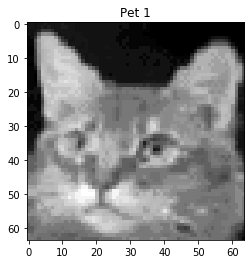

In [3]:
def show_pet(pet_index, data=pets):
    plt.figure()
    # reshape the input data to an image of 64x64 pixels and show it
    plt.imshow(np.reshape(data[pet_index], (64, 64)), cmap = "gray")
    plt.title('Pet '+ str(pet_index))
    plt.show()

show_pet(1, pets)

## Applying data visualization algorithms

In [4]:
%%time
# t-SNE 
from sklearn.manifold import TSNE as tsne
tsne_data = tsne(n_components=2).fit_transform(pets) # to pets
# PCA
from sklearn.decomposition import IncrementalPCA
ipca_data = IncrementalPCA(n_components=3).fit_transform(pets) # set the number of principal components

Wall time: 1.77 s


In [5]:
%matplotlib
ShowScatterPlot(tsne_data, labels_true, 't-SNE for pets', ['t-SNE dimension 1', 't-SNE dimension 2'])

Using matplotlib backend: Qt5Agg


In [6]:
ShowScatterPlot(ipca_data, labels_true, 'PCA for pets', ['1st component', '2nd component','3rd component'])

## Cluster analysis

In [7]:
# K-means clustering
from sklearn.cluster import MiniBatchKMeans as KMeans
from sklearn import metrics

kmeans = KMeans(n_clusters=2, batch_size=8, n_init=1).fit(pets)
cluster_labels = kmeans.labels_

# Show the clustering metrics
print("Done. Adjusted_rand_score =", metrics.adjusted_rand_score(labels_true, cluster_labels))

Done. Adjusted_rand_score = -0.0056842455024445895


In [8]:
ShowScatterPlot(tsne_data, cluster_labels, 't-SNE for pets, cluster data', ['t-SNE dimension 1', 't-SNE dimension 2'])

In [9]:
ShowScatterPlot(ipca_data, cluster_labels, 'PCA for pets', ['1st component', '2nd component','3rd component'])

In [10]:
%matplotlib inline

## Classification

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(pets, labels_true, test_size=0.20, random_state=42)

def TrainGaussianNB():
    # data and labels for training
    print(len(y_train), len(y_test))
    # Gaussian Naive Bayes (GNB)
    clf = GaussianNB()
    clf.fit(x_train, y_train)
    print("Gaussian Naive Bayes accuracy on")
    print("- train data:", clf.score(x_train, y_train)) 
    print("- test data:", clf.score(x_test, y_test)) 
    print("tn, fp, fn, tp - True cats, False dogs, False cats, True dogs")
    print(confusion_matrix(clf.predict(x_test), y_test).ravel())
    return clf

def classLabelToString(class_label):
    return "cat" if class_label < 1 else "dog"

# show an image with labels
def show_result(pet_index, class_label, data=pets):
    plt.figure()
    plt.imshow(np.reshape(data[pet_index], (64, 64)), cmap = "gray")
    plt.title('Test Pet '+ str(pet_index) + '. Classified: ' + classLabelToString(class_label) + ' / Real: ' + classLabelToString(y_test[pet_index]))
    plt.show()

def predict(num, model):
    class_label = model.predict([x_test[num,:]])[0]
    show_result(num, class_label, data=x_test)

model_base = TrainGaussianNB()

128 32
Gaussian Naive Bayes accuracy on
- train data: 0.796875
- test data: 0.8125
tn, fp, fn, tp - True cats, False dogs, False cats, True dogs
[12  2  4 14]


In [12]:
%matplotlib inline

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, fixed
widget = widgets.IntSlider(max=len(x_test)-1,continuous_update=False)
w = interact(predict,num=widget, model=fixed(model_base))

interactive(children=(IntSlider(value=0, continuous_update=False, description='num', max=31), Output()), _dom_…

In [14]:
# Apply edge detection
from skimage.filters import sobel
edge_data = np.empty([160, 4096])
for m in range(160):
    edge_data[m,:] = np.reshape(sobel(np.reshape(pets[m,:], (64,64))), (1,4096))
x_train, x_test, y_train, y_test = train_test_split(edge_data, labels_true, test_size=0.20, random_state=42)

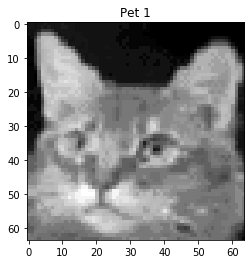

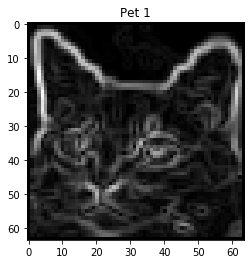

In [15]:
show_pet(1)
show_pet(1, data=edge_data)

In [16]:
model_edge = TrainGaussianNB()

128 32
Gaussian Naive Bayes accuracy on
- train data: 0.921875
- test data: 0.875
tn, fp, fn, tp - True cats, False dogs, False cats, True dogs
[14  2  2 14]


In [17]:
import ipywidgets as widgets
from ipywidgets import interact

widget = widgets.IntSlider(max=len(x_test)-1,continuous_update=False)
w = interact(predict,num=widget, model=fixed(model_edge))

interactive(children=(IntSlider(value=0, continuous_update=False, description='num', max=31), Output()), _dom_…